In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.losses import mse
from functools import partial
import keras.backend as K
import sys
from keras.datasets import mnist
import seaborn as sns
from keras.utils import plot_model

# Dataset Analysis

We use dataset of bank marketing from https://archive.ics.uci.edu/ml/datasets/bank+marketing .

In [152]:
df = pd.read_csv('bank-full.csv', header = 0, sep = ';')

In [153]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


For further analysis let us separate all columns by categorial and continuous features

In [154]:
li_cat = ['job','marital','education','default', 'housing', 'loan', 'contact', 'poutcome', 'y', 'day', 'month']
li_cont = ['age', 'balance', 'duration', 'pdays', 'previous', 'campaign']


As our goal here is to generate fake data, we will need to check the quality of generated data. Here, we will simply compare correlation between features in generated and real data as well as distributions. It would be really hard to estimate if feature generated correctly, if it is not correlated with others. For simplicity, we restrict our attention only on several features which correlated with each others and have not more than 4 categories. Though, the analysis can be extended for other features.

The final lists of categorical and continuous features which we will analize are:

In [155]:
li_cat = ['poutcome', 'marital']
li_cont = ['balance', 'pdays', 'previous', 'campaign', 'age']

Let us check distribution of continuous features:

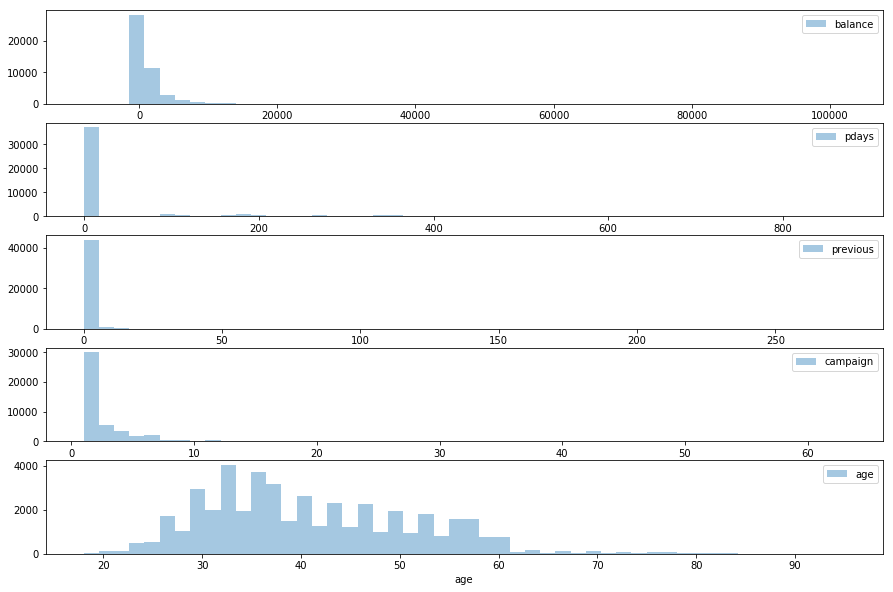

In [156]:
fig = plt.figure(figsize=(15,10))
for ni, i in enumerate(li_cont):
    plt.subplot(len(li_cont), 1, ni+1)
    sns.distplot(df.loc[:, i], kde=False, label = i)
    plt.legend()
plt.show()

There are some outliers in all continous features. Let us clip outliers which are higher than 99 percintile to the 99 percintile

In [157]:
for i in li_cont:
    ser = df.loc[:, i]
    threshold = np.percentile(ser, 99)
    print (i, threshold)
    df.loc[ser>threshold, i] = threshold

balance 13164.900000000001
pdays 370.0
previous 8.900000000001455
campaign 16.0
age 71.0


New features are:

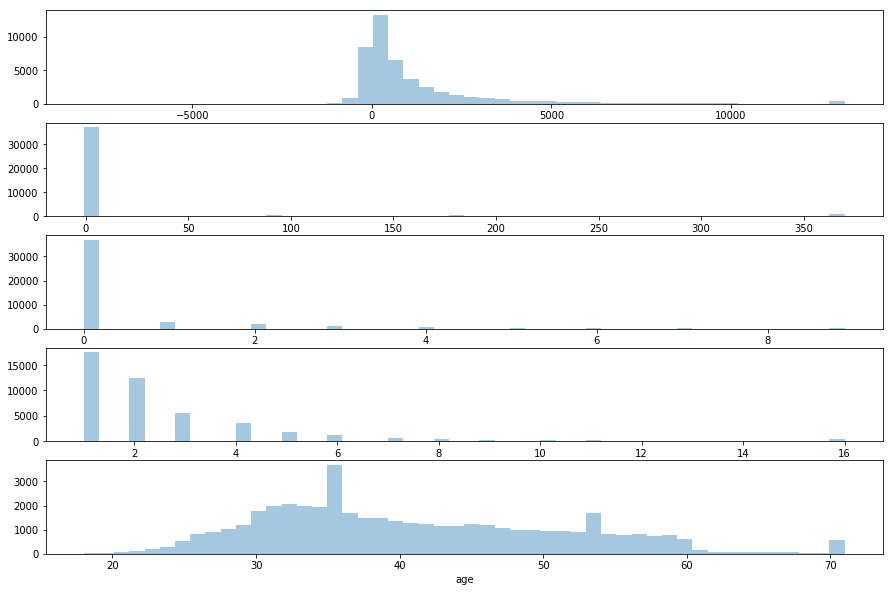

In [158]:
fig = plt.figure(figsize=(15,10))
for ni, i in enumerate(li_cont):
    plt.subplot(len(li_cont), 1, ni+1)
    sns.distplot(df.loc[:, i], kde=False)
plt.show()

There are also two categorical features which we consider. We will use one-hot-encoder to work with categorial features.

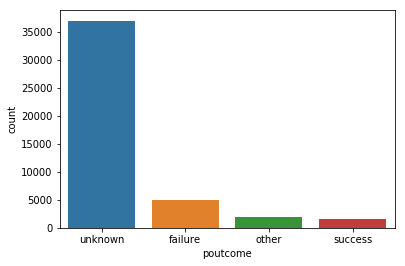

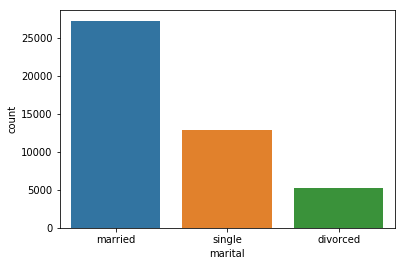

In [159]:
for i in li_cat:
    sns.countplot(x=i, data=df)
    plt.show()

In the next step, we normalize continuous variables and use one-hot-encoding for categorical variable. This is implemented with encode() function, while decode() function makes reverse transformation: from normalized data to real data. Note, that data which are neededfor reverse transformation are saved in normalized.csv during encoding.

In [160]:
def add1(x):
    if x==-1: return x+1
    else: return x

def add1_revert(x):
    if x==0: return x-1
    else: return x

def encode(df, save_normalized=False, soft_labels=False):
    fname_norm = "normalized.csv"
 
    ## categorial variables
    df_cat = df.loc[:,li_cat]
    df_cat = pd.get_dummies(df_cat)

    if soft_labels:
        for i in df_cat.columns:
            df_cat.loc[:, i] = df_cat.loc[:, i] - 0.3*np.random.random(len(df_cat))

    ## continuous variables
    df_cont = df.loc[:, li_cont]
    df_cont.pdays = df_cont.pdays.apply(lambda x: add1(x))
    df_norm = pd.concat([df_cont.mean(), df_cont.max(), df_cont.min()],axis=1)
    df_norm.columns=['meanval', 'maxval', 'minval']
    if save_normalized:
        df_norm.to_csv("normalized.csv")

    df_cont = (df_cont - df_cont.mean())*2. / (df_cont.max() - df_cont.min())
    df_all = pd.concat([df_cat, df_cont], axis=1)
    return df_all


def decode(dfin):

    fname_norm = "normalized.csv"

    df_cont = dfin.loc[:, li_cont]
    df_cat =  dfin.drop(li_cont, axis=1)
    df_norm = pd.read_csv(fname_norm, index_col=0)
    
    df_cont_dec = (df_norm.maxval - df_norm.minval)*df_cont/2. + df_norm.meanval
    df_cont_dec = df_cont_dec.apply(lambda x: round(x,1)).astype(int)
    df_cont_dec.pdays = df_cont_dec.pdays.apply(lambda x: add1_revert(x))

    licol = list(set([i.split('_')[0] for i in df_cat.columns]))
    lidf = []

    for sti in licol:
        li = [i for i in df_cat.columns if sti+'_' in i]
        dfi = df_cat.loc[:,li]
        dic = {i:i.replace(sti+'_', '') for i in dfi.columns}
        dfi = dfi.rename(columns=dic)
        dfi = dfi.idxmax(axis=1)
        dfi.name = sti
        lidf.append(dfi)

    df_cat_dec = pd.concat(lidf, axis=1)

    return pd.concat([df_cat_dec, df_cont_dec], axis=1)


df_all = encode(df, save_normalized=True, soft_labels=False)

cross-correlation of our real data is:

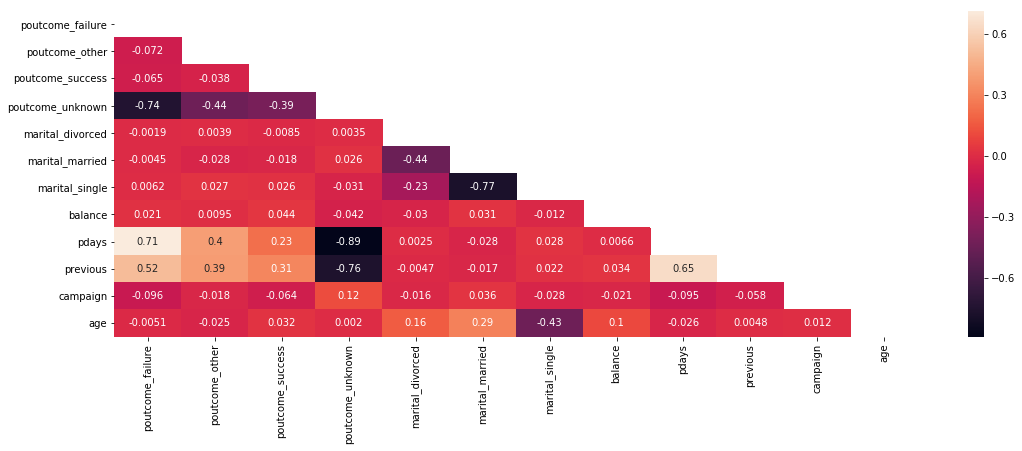

In [161]:
rcorr = df_all.corr()
rcorr.values[np.triu_indices_from(rcorr,0)] = np.nan
plt.figure(figsize=(18,6))
sns.heatmap(rcorr, annot=True)
plt.show()

# Building model

In this part, we will build variational autoencoder. We will use example from https://keras.io/examples/variational_autoencoder/ . First we will define parameters of the model aswell as training. Note, that we want to capture distribution of features in generated data. If we will train VAE on batch which consist of one-row samples, then neural net will no be able to learn distributions of features. That is why we need the value of rows in one sample (NUM_ONE_SAMPLE) be larger than 1. 

In [162]:
NUM_FEATURES = len(df_all.columns)
NUM_ONE_SAMPLE = 20
LATENT_DIM = 10
BATCH_SIZE = 16
FRAC_TEST = 0.8

Build encoder with sampling layer

In [163]:
input_shape = (NUM_ONE_SAMPLE, NUM_FEATURES, )
# VAE model = encoder + decoder
# build encoder model

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

inputs = Input(shape=input_shape, name='encoder_input')
x1 = Flatten()(inputs)
x2 = Dense(NUM_FEATURES*10, activation='relu')(x1)
z_mean = Dense(LATENT_DIM, name='z_mean')(x2)
z_log_var = Dense(LATENT_DIM, name='z_log_var')(x2)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(LATENT_DIM,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 20, 12)       0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 240)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 120)          28920       flatten_4[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           1210        dense_10[0][0]                   
__________________________________________________________________________________________________
z_log_var 

Build decoder

In [164]:
# build decoder model
latent_inputs = Input(shape=(LATENT_DIM,), name='z_sampling')
x3 = Dense(NUM_FEATURES*10, activation='relu')(latent_inputs)
x4 = Dense(NUM_FEATURES*NUM_ONE_SAMPLE, activation='tanh')(x3)
outputs = Reshape((NUM_ONE_SAMPLE, NUM_FEATURES))(x4)
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 120)               1320      
_________________________________________________________________
dense_12 (Dense)             (None, 240)               29040     
_________________________________________________________________
reshape_4 (Reshape)          (None, 20, 12)            0         
Total params: 30,360
Trainable params: 30,360
Non-trainable params: 0
_________________________________________________________________


Connect decoder and encoder. Define loss function:

In [165]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = K.sum(mse(inputs, outputs), axis=-1)
reconstruction_loss *= NUM_FEATURES*NUM_ONE_SAMPLE


kl_loss = - 1 + K.exp(z_log_var) - z_log_var + K.square(z_mean) 
kl_loss = K.sum(kl_loss, axis=-1)


alpha = 0.5
vae_loss = K.mean(reconstruction_loss + alpha*kl_loss)


vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 20, 12)            0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  31340     
_________________________________________________________________
decoder (Model)              (None, 20, 12)            30360     
Total params: 61,700
Trainable params: 61,700
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [166]:
arr_all = df_all.values
train_num  = int(len(arr_all)*FRAC_TEST/NUM_ONE_SAMPLE)*NUM_ONE_SAMPLE
index = np.random.choice(len(arr_all), train_num, replace=False)  

X_train = arr_all[index].reshape(-1, NUM_ONE_SAMPLE, NUM_FEATURES)

X_test = arr_all[np.setxor1d(np.arange(len(arr_all)), index)]
len_test = int(X_test.shape[0]/NUM_ONE_SAMPLE)*NUM_ONE_SAMPLE

X_test = X_test[:len_test].reshape(-1, NUM_ONE_SAMPLE, NUM_FEATURES)

epochs=10
vae.fit(X_train,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, None))

Train on 1808 samples, validate on 452 samples
Epoch 1/10
1808/1808 [==============================] - 2s 1ms/step - loss: 733.2955 - val_loss: 623.0231
Epoch 2/10
1808/1808 [==============================] - 1s 406us/step - loss: 606.3599 - val_loss: 587.9515
Epoch 3/10
1808/1808 [==============================] - 1s 327us/step - loss: 579.5651 - val_loss: 567.6185
Epoch 4/10
1808/1808 [==============================] - 1s 333us/step - loss: 562.1002 - val_loss: 556.3331
Epoch 5/10
1808/1808 [==============================] - 1s 349us/step - loss: 549.9148 - val_loss: 549.3861
Epoch 6/10
1808/1808 [==============================] - 1s 344us/step - loss: 540.6510 - val_loss: 542.8151
Epoch 7/10
1808/1808 [==============================] - 1s 337us/step - loss: 532.8196 - val_loss: 539.7441
Epoch 8/10
1808/1808 [==============================] - 1s 332us/step - loss: 525.5990 - val_loss: 536.2877
Epoch 9/10
1808/1808 [==============================] - 1s 333us/step - loss: 519.0180 - va

# Evaluation

In this section, we will evaluate trained model. For that purpose, we first check the distribution of means and variances (outputs of encoder). The more weight alpha has in KL-Loss function, the closer mean will be to 0 and variance to 1.

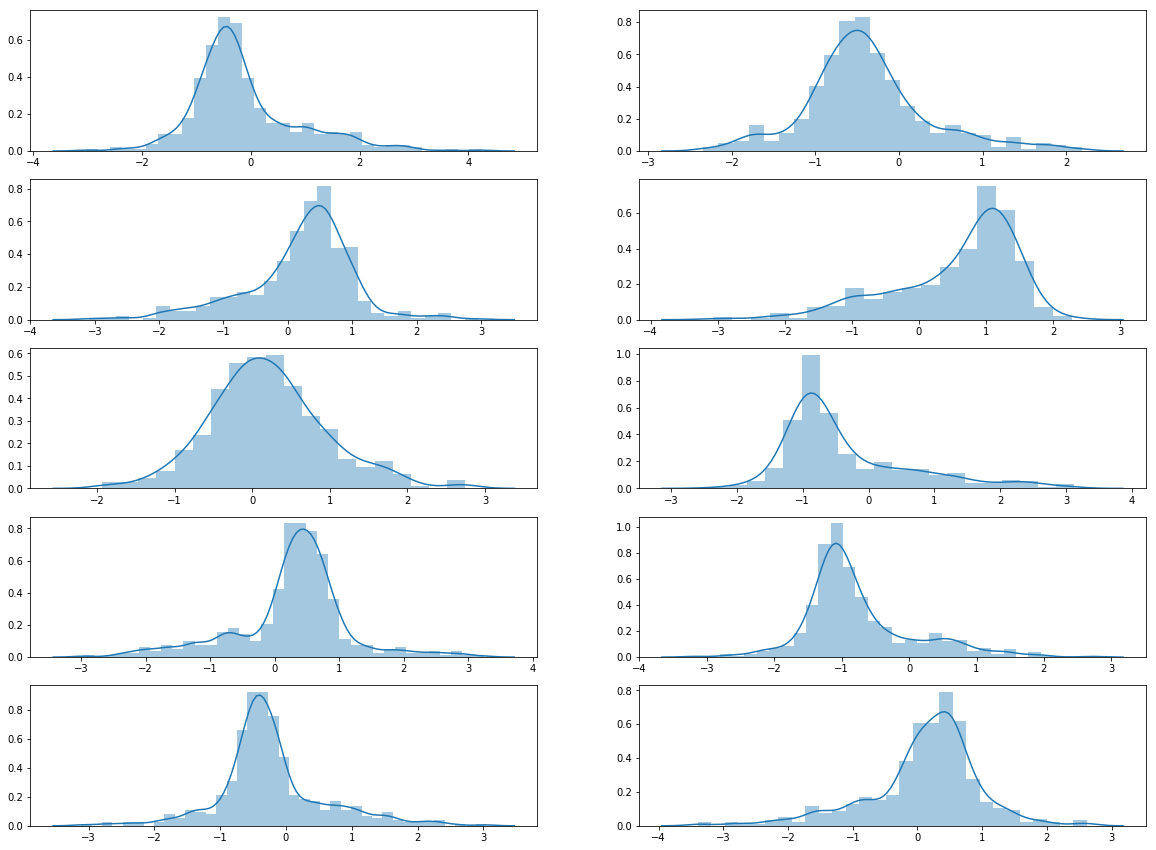

In [167]:
dist = encoder.predict(X_test)
mean = dist[0]
var = dist[1]
fig = plt.figure(figsize=(20,15))
for i in range(LATENT_DIM):
    plt.subplot(5,2,i+1)
    sns.distplot(mean[:,i])
plt.show()

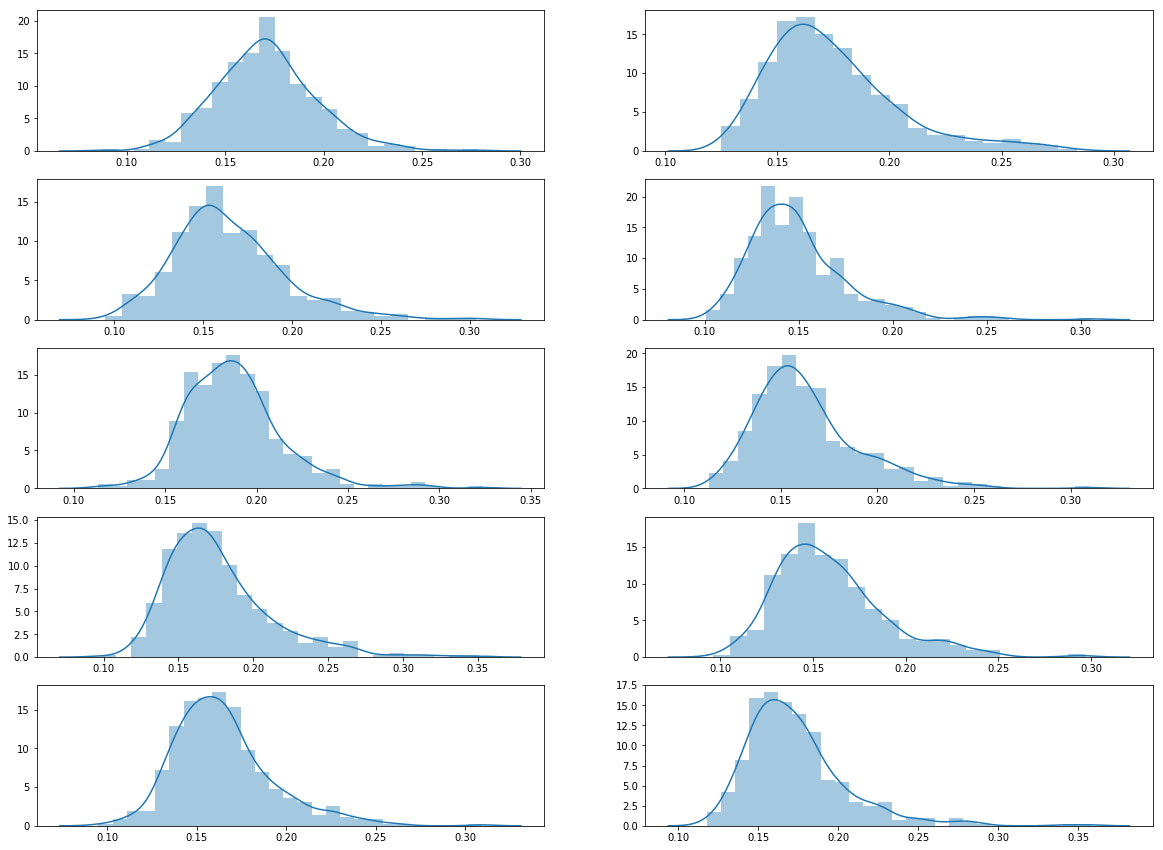

In [168]:
fig = plt.figure(figsize=(20, 15))
for i in range(LATENT_DIM):
    plt.subplot(5,2,i+1)
    sns.distplot(np.exp(0.5*var[:,i]))
plt.show()

To generate the 'fake' data, we will sample values for decoder from normal distribution. However, mean and variance for this notmal distribution we will randomly choose from outputs of encoder.

In [169]:
def generate_predictions(num_samples, cols):
    num_samples = int(num_samples/NUM_ONE_SAMPLE)
    idx = np.random.choice(len(mean), num_samples)
    lat_ar = np.array([[np.random.normal(m, np.exp(0.5*v)) for m,v in  zip(mean[i], var[i])] for i in idx])
    pred = decoder.predict(lat_ar)
    df_pred = pd.DataFrame.from_records(pred.reshape(-1, NUM_FEATURES), columns=df_all.columns)
    df_pred = pd.DataFrame.from_records(pred.reshape(-1, NUM_FEATURES), columns=df_all.columns)
    return encode(decode(df_pred))

In [170]:
fake = generate_predictions(len(df_all), df_all.columns)

Let us compare correlation of features in real and fake data. 

What can you tell about the quality of generated data? 
Which features are generated well, and which are not?

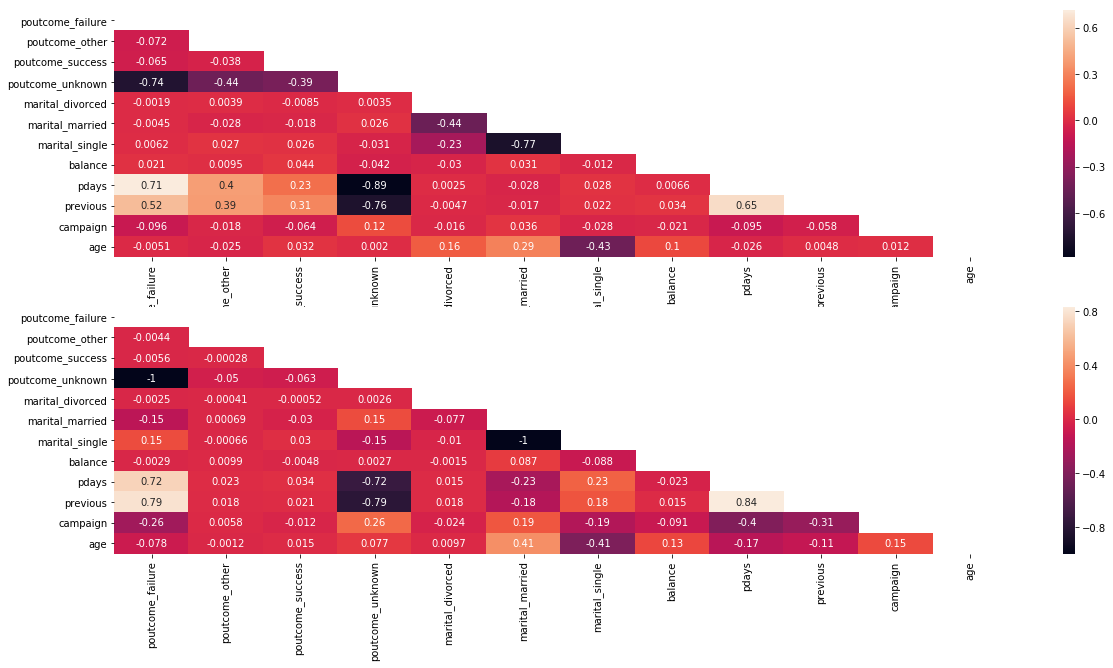

In [171]:
rcorr = df_all.corr()
rcorr.values[np.triu_indices_from(rcorr,0)] = np.nan

fcorr = fake.corr()
fcorr.values[np.triu_indices_from(fcorr,0)] = np.nan
plt.figure(figsize=(20,10))
plt.subplot(211)
sns.heatmap(rcorr, annot=True)
plt.subplot(212)
sns.heatmap(fcorr, annot=True)
plt.show()

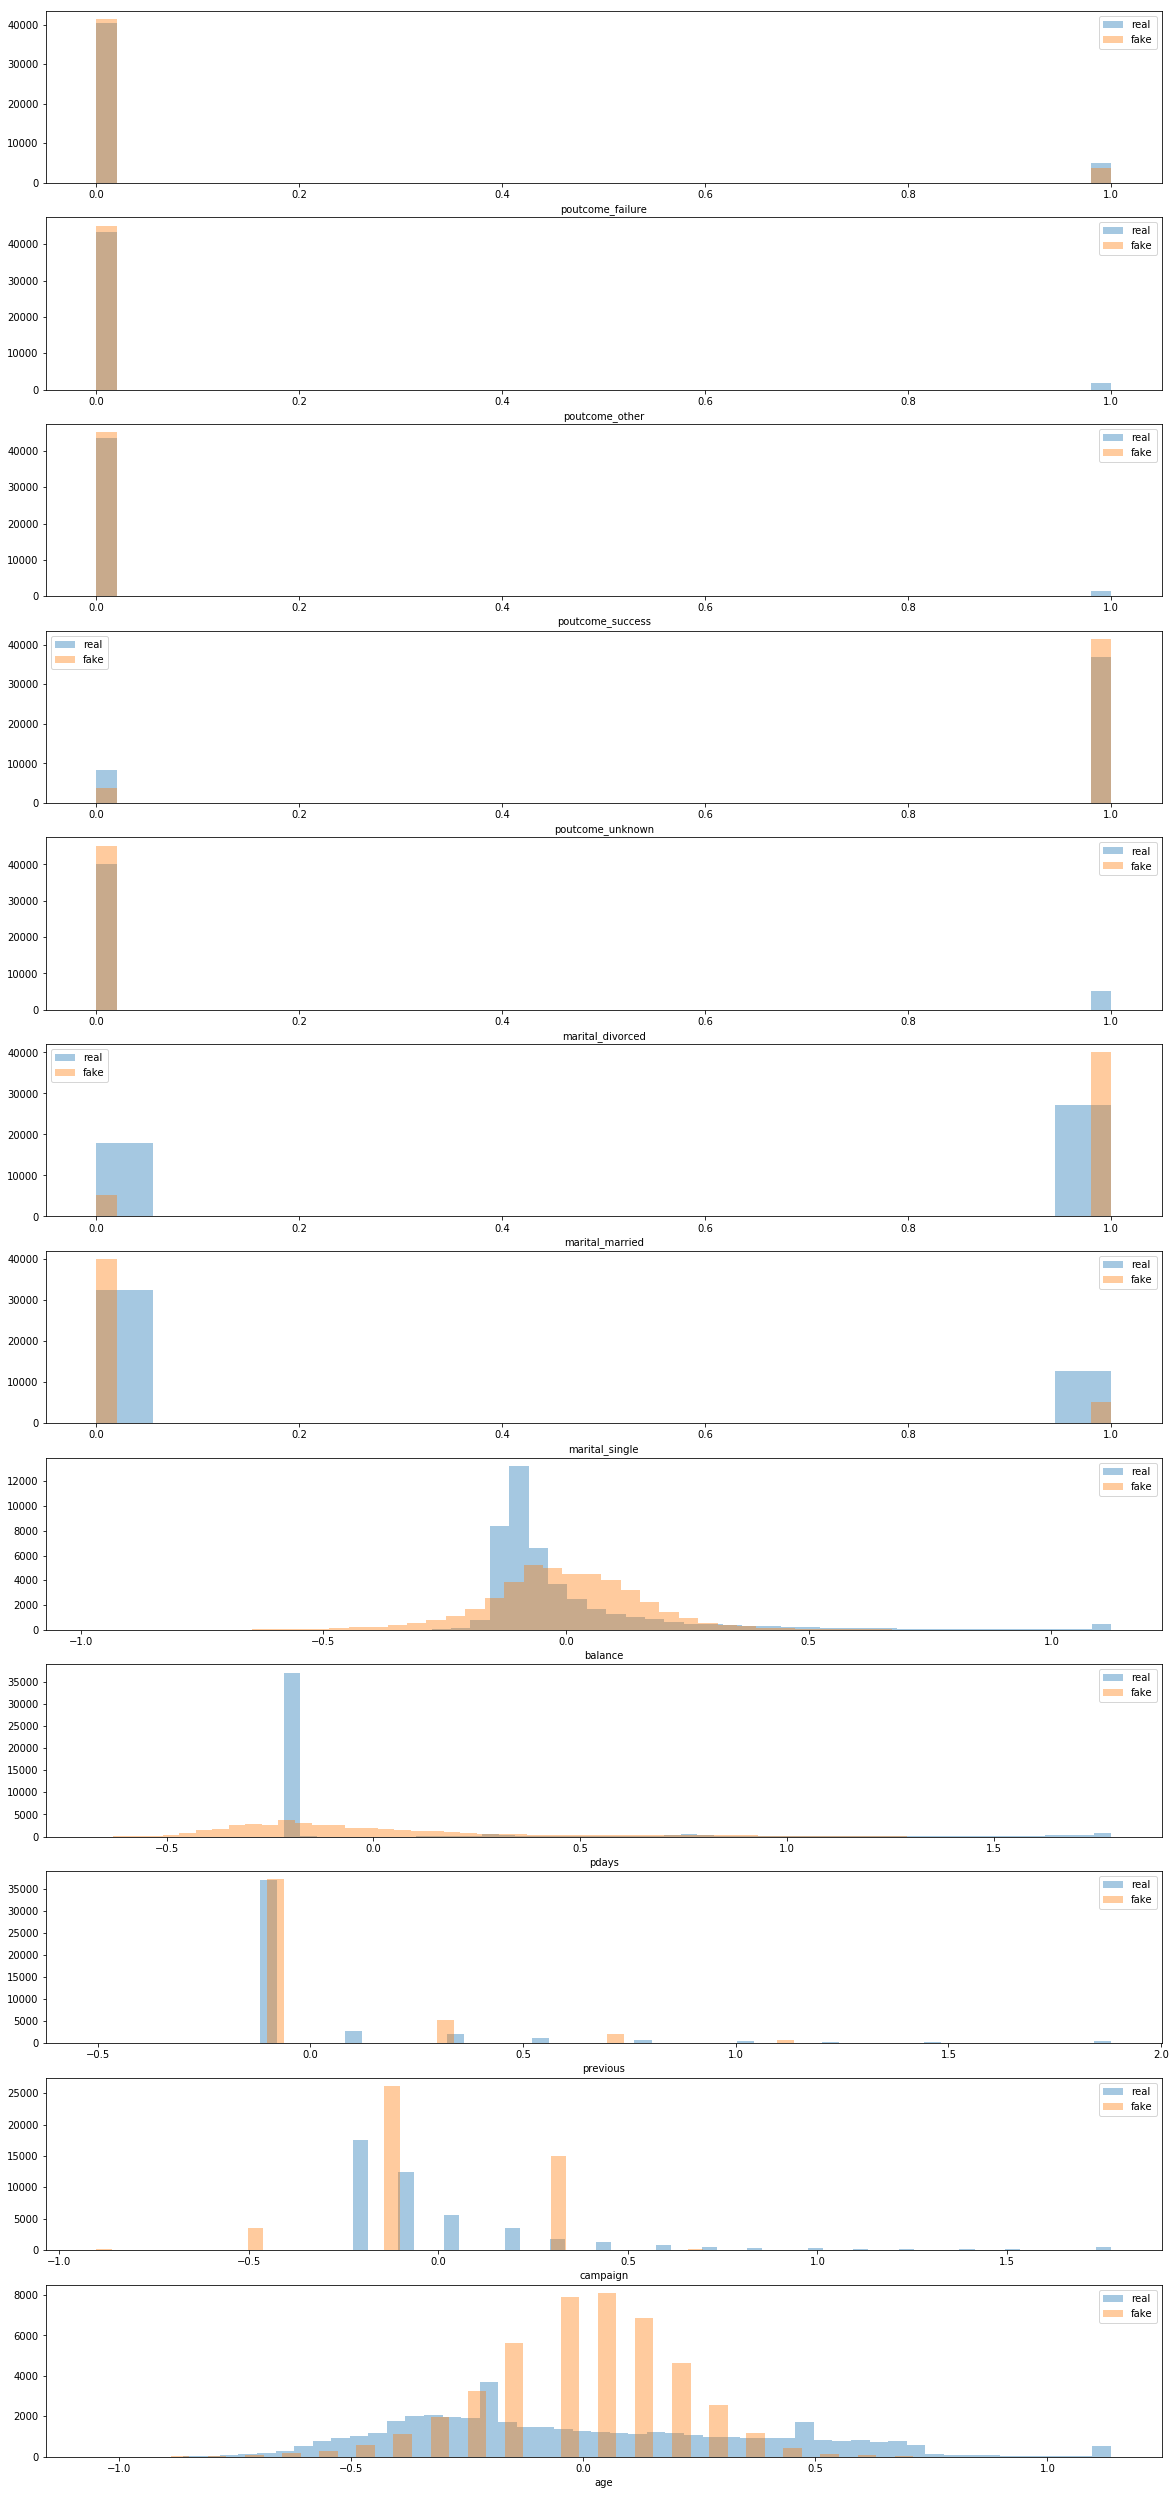

In [172]:
fig = plt.figure(figsize=(20, 45))
for ni, coli in enumerate(list(df_all.columns)):
    ax1 = plt.subplot(NUM_FEATURES,1,ni+1)
    sns.distplot(df_all.loc[:,coli], kde=False, ax=ax1, label='real')
    try:
        sns.distplot(fake.loc[:,coli], kde=False, ax=ax1, label='fake')
    except:
        pass
    plt.legend()
plt.show()

# Tasks for the current dataset

Play-around:
    1. Change alpha in KL-loss function to 0 and retrain. What will happen with distributions of mean and variance?
    2. Set alpha to large values and retrain. What will happen to the distributions then?
    
Improve evaluation of the generated data:
    1. Build a plot with conditional probability of two feature for real and generated data. 
    2. Write a function to evaluate difference between correlation of generated and real data. For example, you can tak mse of difference between corresponding correlations. Evaluate the function during training. Does difference decrease during the training?
    3. Train unsupervised clusttering algorithm (PCA, K-means) on real data. Try to use it for fake data and compare results. 
    4. Try to find Nearest Neighbors https://scikit-learn.org/stable/modules/neighbors.html for all elements of generated data among real data.
    5. What would be the average distance (one could use mse) between samples of generated data and neighbors from fake data?
    
Improve data generation:
    1. Add more features for analysis, such as education.
    2. Try to change following parameters: LATENT_DIM, NUM_ONE_SAMPLE, alpha, number of layers and number of nodes in these layers. Does it improve generated data quality or speed of training?